In [2]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import pickle

from models.value_models import ValueLinearModel, ValueNormedModel
from models.multinomial_logistic_regressor import MultinomialLogisticRegressor, NormedMultinomialLogisticRegressor
from models.model_wrapper import ModelWrapper

from models.trainer import Trainer

import torch

import plotly.express as px


matplotlib.rcParams['figure.dpi'] = 300


species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

In [3]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)

In [3]:
def spikes_features(ax): 
    feature_dims = ["Color", "Shape", "Pattern"]
    colors = ["tab:purple", "tab:olive", "tab:cyan"]
    pre_interval = 1300
    post_interval = 1500

    for feature_dim, color in zip(feature_dims, colors):
        acc = np.load(fs.open(f"l2l.pqz317.scratch/{feature_dim}_torch_normed_lr_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))
        shuffled = np.load(fs.open(f"l2l.pqz317.scratch/{feature_dim}_torch_normed_lr_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))

        # generate figures
        visualization_utils.visualize_accuracy_across_time_bins(
            acc,
            pre_interval, post_interval, 100,
            ax,
            label=f"{feature_dim}",
            right_align=True,
            color=color
        )

    ax.axvspan(-800, 0, alpha=0.3, color='gray')
    ax.axvline(98, alpha=0.3, color='gray', linestyle='dashed')
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_ylabel("Decoder Accuracy")
    # ax.set_title(f"Decoding Selected Features with Spiking")
    ax.legend()

def spikes_choice(ax):
    pre_interval = 1300
    post_interval = 1500

    test_accs = np.load(fs.open(f"l2l.pqz317.scratch/value_normed_model_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))

    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs,
        pre_interval, post_interval, 100,
        ax,
        label="Choice",
        right_align=True,
        color="tab:red"
    )

    ax.axvspan(-800, 0, alpha=0.3, color='gray')
    ax.axvline(98, alpha=0.3, color='gray', linestyle='dashed')
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    # ax.set_title(f"Decoding Choice with 100ms Bins of Spiking")
    ax.legend()

def lfps_feature(ax):
    feature_dim = "Pattern"
    colors = ["C0", "C1", "C2"]
    freqs = ["bp_4-5", "bp_10-13", "bp_20-24"]
    names = ["4-5 Hz", "10-13 Hz", "20-24 Hz"]
    pre_interval = 1300
    post_interval = 1500
    for color, name, freq in zip(colors, names, freqs):
        acc = np.load(fs.open(f"l2l.pqz317.scratch/{feature_dim}_normed_lr_lfp_{freq}_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))
        visualization_utils.visualize_accuracy_across_time_bins(
            acc,
            pre_interval, post_interval, 100,
            ax,
            label=f"{name} Pattern",
            right_align=False,
            color=color
        )
    ax.axvspan(-800, 0, alpha=0.3, color='gray')
    ax.axvline(98, alpha=0.3, color='gray', linestyle='dashed')
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Decoder Accuracy")
    # ax.set_title(f"Decoding {feature_dim} with 100ms Samples of LFP Freq Bands")
    ax.legend()

def lfps_choice(ax):
    colors = ["C0", "C1", "C2"]
    freqs = ["bp_4-5", "bp_10-13", "bp_20-24"]
    names = ["4-5 Hz", "10-13 Hz", "20-24 Hz"]
    pre_interval = 1300
    post_interval = 1500
    for color, name, freq in zip(colors, names, freqs):
        acc = np.load(fs.open(f"l2l.pqz317.scratch/value_model_lfp_{freq}_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))
        visualization_utils.visualize_accuracy_across_time_bins(
            acc,
            pre_interval, post_interval, 100,
            ax,
            label=f"{name} Choice",
            right_align=False,
            color=color
        )
    ax.axvspan(-800, 0, alpha=0.3, color='gray')
    ax.axvline(98, alpha=0.3, color='gray', linestyle='dashed')
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time (ms)")
    # ax.set_title(f"Decoding Choice with 100ms Samples of LFP Freq Bands")
    ax.legend()


In [48]:
matplotlib.rcParams.update({'font.size': 34})
fig, ax = plt.subplots(2, 2, figsize=(30, 20), sharex=True, sharey='row')
fig.tight_layout(pad=0)
spikes_features(ax[0][0])
ax[0][0].text(-1300, 0.58, "a", fontsize=50, fontweight='bold')
spikes_choice(ax[0][1])
ax[0][1].text(-1300, 0.58, "b", fontsize=50, fontweight='bold')

lfps_feature(ax[1][0])
ax[1][0].text(-1300, 0.45, "c", fontsize=50, fontweight='bold')

lfps_choice(ax[1][1])
ax[1][1].text(-1300, 0.45, "d", fontsize=50, fontweight='bold')

fig.savefig("../data/combined.pdf")

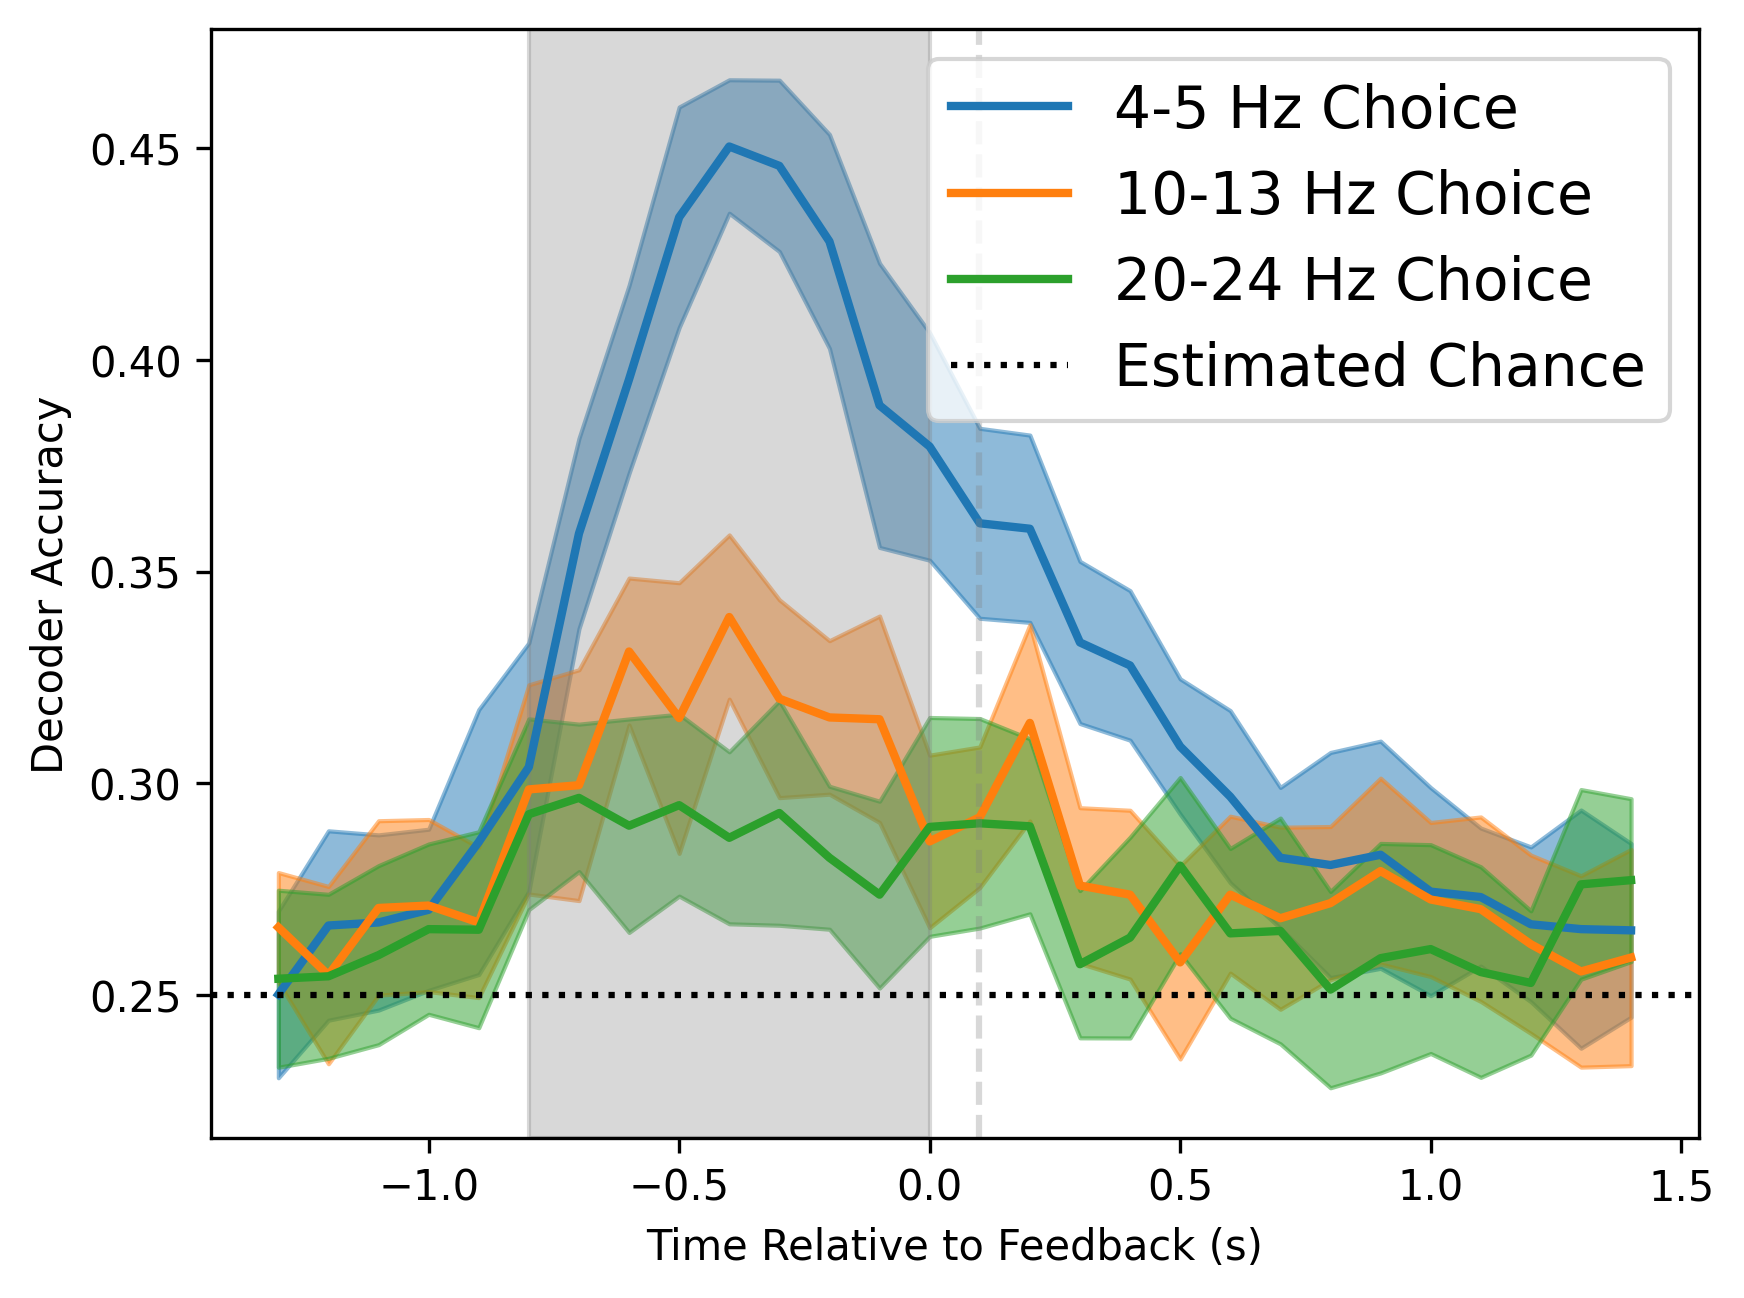

In [4]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()

colors = ["C0", "C1", "C2"]
freqs = ["bp_4-5", "bp_10-13", "bp_20-24"]
names = ["4-5 Hz", "10-13 Hz", "20-24 Hz"]
pre_interval = 1300
post_interval = 1500
for color, name, freq in zip(colors, names, freqs):
    acc = np.load(fs.open(f"l2l.pqz317.scratch/value_model_lfp_{freq}_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))
    visualization_utils.visualize_accuracy_across_time_bins(
        acc,
        1.3, 1.5, 0.1,
        ax,
        label=f"{name} Choice",
        right_align=False,
        color=color
    )
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")
# ax.set_title(f"Decoding Choice with 100ms Samples of LFP Freq Bands")
ax.legend(prop={'size': 14})